
# Predicting Rate of Penetration (ROP) in Oil and Gas Drilling

This project involves using machine learning to predict the Rate of Penetration (ROP) during well drilling operations in the Oil and Gas industry. The aim is to provide accurate ROP predictions to improve cost estimations for future drilling projects, leading to better budgeting and project planning.

## Objectives
1. Predict ROP based on historical drilling data.
2. Evaluate the performance of different machine learning models.
3. Identify key factors influencing ROP.

The data for this project is obtained from real drilling operations, making the findings relevant to real-world scenarios in the Oil and Gas industry.



# Data Overview

The dataset used in this project is sourced from actual drilling data and contains various features such as depth, weight on bit, rotational speed, and mud flow rate. These features are considered influential factors in determining the Rate of Penetration.

### Key Features
- **Depth**: The depth of the drilling operation.
- **Weight on Bit (WOB)**: The force applied to the drill bit.
- **Rotational Speed (RPM)**: The speed at which the drill bit rotates.
- **Mud Flow Rate**: The rate at which drilling fluid is circulated.

The dataset contains several wells' data, with various drilling parameters recorded at different depths.

In [1]:
# Install libraries before executing the next steps

#!pip install lasio
#!pip install xgboost

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lasio
import matplotlib.pyplot as plt
import requests
from io import StringIO

# Jupyter Notebook Configurations
%matplotlib inline

# Preprocessing and ML Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# Configuring pipeline visualization
from sklearn import set_config
set_config(display='diagram')

# Data Load

In [3]:
# Datasets
mip3 = lasio.read("database/3H_BottomHole1440325201Depth.las").df()
mip5t = lasio.read("database/5H_Top1435428151Depth.las").df()
mip5b = lasio.read("database/5H_Bottom1441631652Depth.las").df()
sw = lasio.read("database/SW1442084965Depth.las").df()

# Shape of each dataset
print('mip3 shape: ',mip3.shape)
print('mip5t shape: ',mip5t.shape)
print('mip5b shape: ',mip5b.shape)
print('sw shape: ', sw.shape)

# Concatenate the training datasets
df = pd.concat([mip3, mip5b, mip5t]).reset_index(drop=False)
print('Concatenated training dataset shape:', df.shape)

# Move the 'ROP' column to the first position
rop_column = df.pop('ROP')
df.insert(0, 'ROP', rop_column)

# Prepare the validation dataset
sw = sw.reset_index(drop=False)
sw_rop_column = sw.pop('ROP')
sw.insert(0, 'ROP', sw_rop_column)

mip3 shape:  (9091, 157)
mip5t shape:  (6465, 82)
mip5b shape:  (7999, 172)
sw shape:  (7553, 91)
Concatenated training dataset shape: (23555, 186)



# Exploratory Data Analysis (EDA)

In this section, we will perform EDA to understand the characteristics of the dataset. We will look at distributions of key features, correlations, and identify any data quality issues such as missing values.


In [4]:
# Perform EDA on the concatenated dataset
print("Dataset Info:")
df.info()

# Display first few rows of the concatenated and validation datasets
print("\nTraining and Testing Dataset Preview:")
print(df.head())

print("\nValidation Dataset Preview:")
print(sw.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23555 entries, 0 to 23554
Columns: 186 entries, ROP to WIT3
dtypes: float64(186)
memory usage: 33.4 MB

Training and Testing Dataset Preview:
    ROP  DEPT  BDEP  TC_3     TOP    HL  SPP  SPM1  SPM2  RPM  ...  GV0  H2S  \
0  0.32   1.0   1.0  94.0  187.35  43.6  0.0   0.0   0.0  0.0  ...  NaN  NaN   
1  0.00   2.0   2.0  94.0     NaN  39.4  0.0   0.0   0.0  0.0  ...  NaN  NaN   
2  0.00   3.0   3.0  94.0     NaN  39.3  0.0   0.0   0.0  0.0  ...  NaN  NaN   
3  0.00   4.0   4.0  94.0     NaN  39.2  0.0   0.0   0.0  0.0  ...  NaN  NaN   
4  0.00   5.0   5.0  94.0     NaN  39.3  0.0   0.0   0.0  0.0  ...  NaN  NaN   

   N2P  N2VI  HCF  N2VO  CONO  WIT1  WIT2  WIT3  
0  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
1  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
2  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
3  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  
4  NaN   NaN  NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 18

# Data Preprocessing

The following steps will be taken to prepare the dataset for modeling:
1. **Drop columns with all missing values**: Removes features that don't have any data.
2. **Fill in missing values**: Use the column mean to replace missing data.
3. **Standardize the data**: Scale features to have a mean of 0 and a standard deviation of 1.
4. **Select important features**: Use `ExtraTreesRegressor` to identify and keep only the most relevant features.
5. **Add the `ROP` target variable back**: Include `ROP` for visualizations to show its relationship with the selected features.
6. **Split into training and testing sets**: Divide the data for model training and evaluation.
7. **Visualize the data**: Plot histograms to show feature distributions and a correlation heatmap to see relationships between features and `ROP`.



Number of selected features: 13 out of 172
Training set size: 18844 samples
Testing set size: 4711 samples


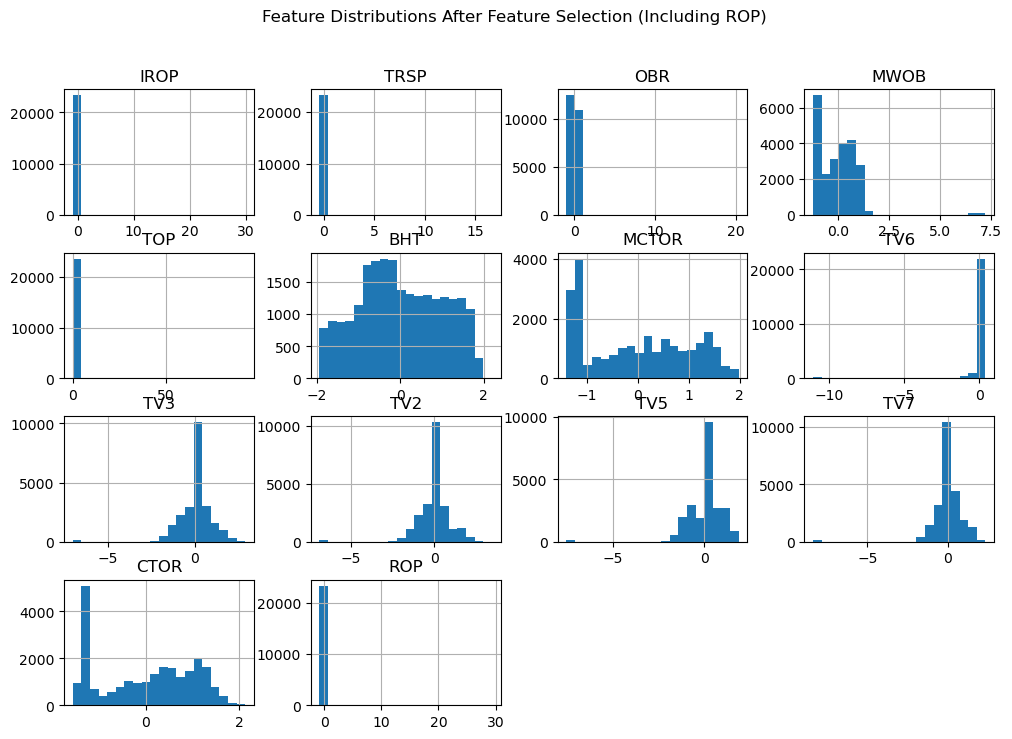

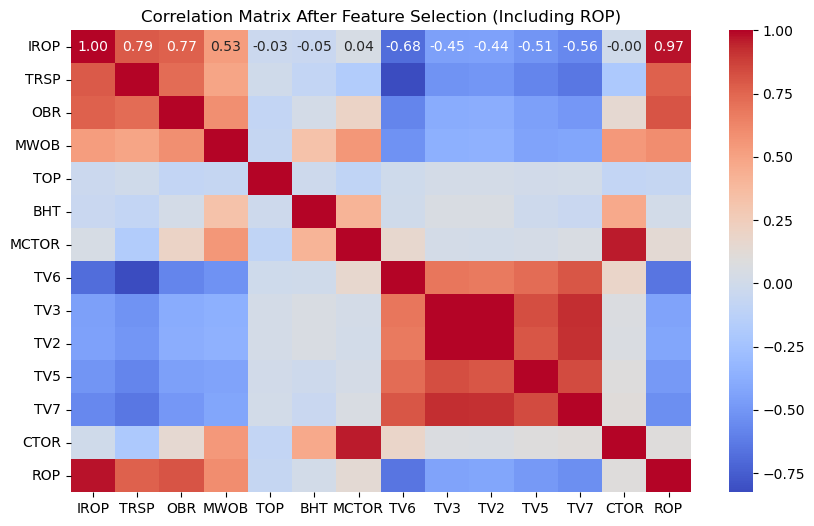

In [5]:
# Step 1: Remove columns that contain only missing values
df_filtered = df.dropna(axis=1, how='all')

# Step 2: Handling missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df_filtered)

# Step 3: Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Step 4: Convert scaled data back to a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=df_filtered.columns)

# Step 5: Splitting the dataset into features and target variable
X = data_scaled.drop('ROP', axis=1)  # Assuming 'ROP' is the target column
y = data_scaled['ROP']

# Step 6: Feature selection using ExtraTreesRegressor
feature_selector = ExtraTreesRegressor(n_estimators=100, random_state=42)
feature_selector.fit(X, y)

# Get feature importances
feature_importances = feature_selector.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Set a threshold for feature importance (e.g., mean importance)
threshold = feature_importance_df['Importance'].mean()

# Select features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

print(f"Number of selected features: {len(selected_features)} out of {X.shape[1]}")

# Step 7: Filter the original dataset to keep only the selected features
X_selected = X[selected_features]

# Step 8: Create a new DataFrame that includes 'ROP' for visualization
X_selected_with_rop = X_selected.copy()
X_selected_with_rop['ROP'] = y

# Step 9: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

# Step 10: Visualizations including ROP

# Plotting histograms of the selected features (including ROP)
X_selected_with_rop.hist(figsize=(12, 8), bins=20)
plt.suptitle('Feature Distributions After Feature Selection (Including ROP)')
plt.show()

# Correlation heatmap including ROP
plt.figure(figsize=(10, 6))
sns.heatmap(X_selected_with_rop.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Feature Selection (Including ROP)')
plt.show()


# Modeling

In this section, we will implement several machine learning models, tune their hyperparameters, and compare their performances. The models to be used include:
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Decision Tree
- Random Forest
- Extra Trees
- XGBoost

Each model will be evaluated using cross-validation and performance metrics such as Mean Squared Error (MSE) and R-squared.


In [6]:
# Defining a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2

# Dictionary to store model performances
model_performances = {}

# List of models
models = {
    'KNN': KNeighborsRegressor(),
    'SVM': SVR(kernel='rbf', gamma=1.5, C=5),
    'Decision Tree': DecisionTreeRegressor(random_state=1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=1, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=1, n_jobs=-1)
}

# Evaluating each model
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_performances[model_name] = {'MSE': mse, 'R2': r2}
    print(f'{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}')

KNN - MSE: 0.0055, R2: 0.9923
SVM - MSE: 0.2781, R2: 0.6088
Decision Tree - MSE: 0.0007, R2: 0.9990
Random Forest - MSE: 0.0007, R2: 0.9990
Extra Trees - MSE: 0.0002, R2: 0.9997
XGBoost - MSE: 0.0074, R2: 0.9896



# Model Evaluation

The performance of each model is compared based on Mean Squared Error (MSE) and R-squared metrics. The lower the MSE, the better the model's accuracy, and the closer the R-squared value is to 1, the better the model explains the variance in the data.


In [7]:
# Displaying model performances in a DataFrame
performance_df = pd.DataFrame(model_performances).T
performance_df.sort_values(by='R2', ascending=False, inplace=True)
performance_df

,MSE,R2
Extra Trees,0.000180,0.999747
Decision Tree,0.000700,0.999015
Random Forest,0.000725,0.998981
KNN,0.005483,0.992288
XGBoost,0.007418,0.989565
SVM,0.278091,0.608807


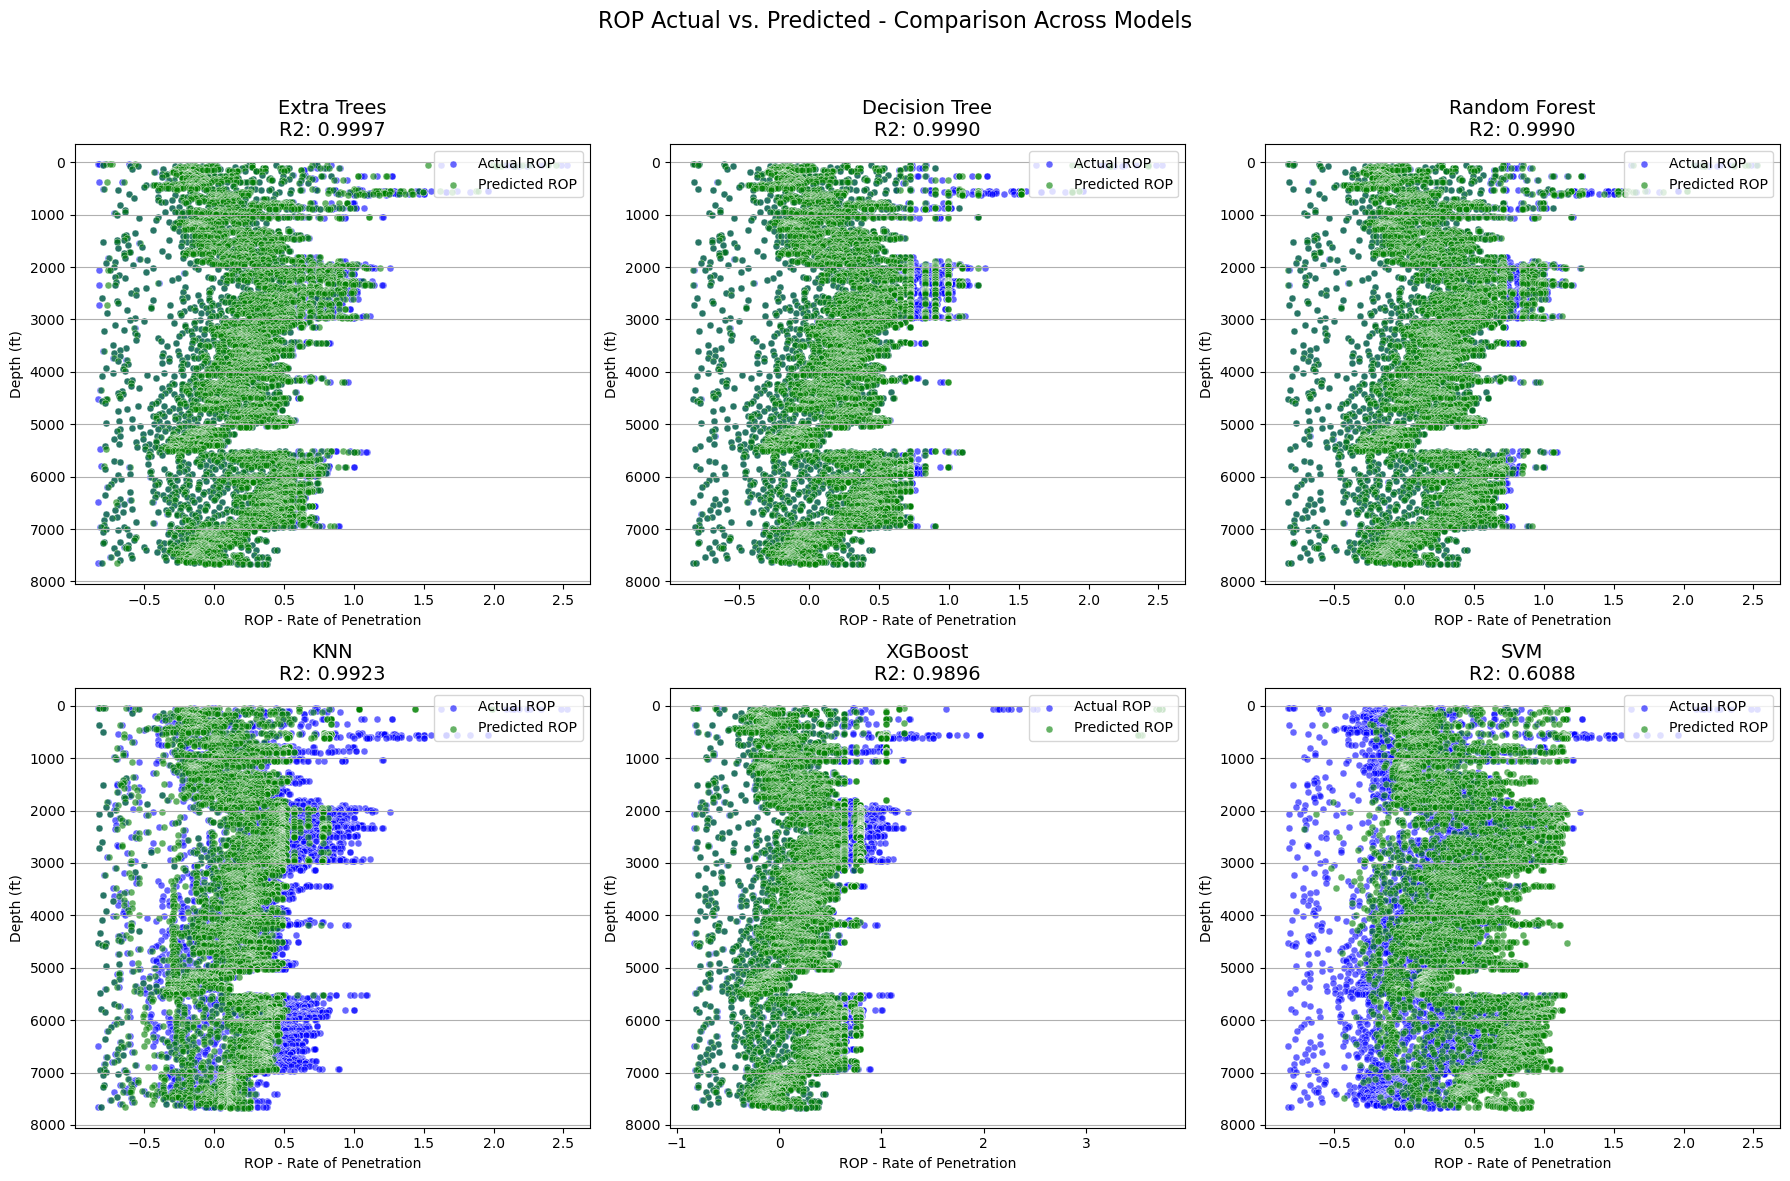

In [9]:
# Step 1: Preprocess the validation dataset (sw) similarly to the training data
# Align the columns of sw_filtered with df_filtered (training data)
sw_filtered = sw.copy()

sw_filtered = sw_filtered.reindex(columns=df_filtered.columns, fill_value=np.nan)

# Impute missing values using the mean (using the trained imputer from training data)
sw_imputed = imputer.transform(sw_filtered)

# Standardize the features (using the trained scaler from training data)
sw_scaled = scaler.transform(sw_imputed)

# Convert scaled validation data to a DataFrame
sw_scaled = pd.DataFrame(sw_scaled, columns=sw_filtered.columns)

# Select only the features used in the model (excluding 'ROP' as it's not part of the feature set)
sw_selected = sw_scaled[selected_features]

# Get the actual ROP values and depth from the validation dataset
y_blind = sw_scaled['ROP']
depth_blind = sw['DEPT']


# Step 2: Define the Function to Plot the Models Side by Side
import warnings

def plot_rop_comparison_by_depth_multiple(models, performance_df, y_blind, depth_blind, sw_selected):
    """
    Generates subplots comparing actual and predicted ROP by depth for multiple models, ordered by R2 score.
    
    Parameters:
    - models: Dictionary containing the trained models
    - performance_df: DataFrame containing the R2 scores for each model, sorted in descending order
    - y_blind: Actual ROP values for the validation dataset
    - depth_blind: Depth values corresponding to the ROP measurements
    - sw_selected: Preprocessed features used for prediction
    """
    # Create a figure with subplots for each model, ordered by R2 score
    n_models = len(models)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust according to the number of models
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    fig.suptitle('ROP Actual vs. Predicted - Comparison Across Models', fontsize=16)
    
    # Suppress warnings temporarily
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        
        # Generate the plots for each model in the order specified by performance_df
        for i, model_name in enumerate(performance_df.index):
            model = models[model_name]
            # Predict on the validation data
            y_pred_blind = model.predict(sw_selected)
            
            # Scatter plot for actual vs. predicted ROP by depth
            sns.scatterplot(x=y_blind, y=depth_blind, label='Actual ROP', color='blue', s=25, alpha=0.6, ax=axes[i])
            sns.scatterplot(x=y_pred_blind, y=depth_blind, label='Predicted ROP', color='green', s=25, alpha=0.6, ax=axes[i])
            axes[i].invert_yaxis()  # Invert y-axis to show depth increasing downward
            r2_score_value = performance_df.loc[model_name, 'R2']
            axes[i].set_title(f'{model_name}\nR2: {r2_score_value:.4f}', fontsize=14)
            axes[i].set_xlabel('ROP - Rate of Penetration')
            axes[i].set_ylabel('Depth (ft)')
            axes[i].grid(axis='y')
            axes[i].legend(loc='upper right')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('rop_comparison_plot.png', dpi=300)  # Save with high resolution
    plt.show()

# Step 3: Call the function to plot all models in one figure in the sorted order
plot_rop_comparison_by_depth_multiple(models, performance_df, y_blind, depth_blind, sw_selected)

# Conclusion and Next Steps

The results clearly indicate that the **Extra Trees** model outperformed the others, achieving the high `R2` score (0.9997) and the lowest `MSE` (0.000180), making it the most effective model for predicting ROP in drilling operations. The Decision Tree and Random Forest models also performed well, showing strong predictive capabilities, while KNN and XGBoost lagged slightly behind. The SVM model, however, struggled with a significantly lower `R2` score (0.6088), suggesting it may not be well-suited for this particular problem.

### Next Steps
1. Focus on fine-tuning the Extra Trees model further to push performance even closer to the theoretical maximum.
2. Explore feature engineering techniques to enhance the model's accuracy, potentially by incorporating additional domain-specific data or deriving new features.
3. Revisit the lower-performing models (like SVM) and assess if specific adjustments, such as kernel functions or scaling methods, could improve their performance.
4. Consider implementing a neural network to see if it can capture any complex relationships the tree-based models might be missing.
5. Validate the model with new or unseen data to ensure its robustness in real-world applications.